In [4]:
!pip install opencv-python opencv-contrib-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---- ----------------------------------- 4.7/39.5 MB 23.7 MB/s eta 0:00:02
   ------------- -------------------------- 12.8/39.5 MB 32.2 MB/s eta 0:00:01
   ------------------------ --------------- 23.9/39.5 MB 38.7 MB/s eta 0:00:01
   --------------------------------- ------ 32.8/39.5 MB 39.2 MB/s eta 0:00:01
   ---------------------------------------  39.3/39.5 MB 39.7 MB/s eta 0:00:01
   ---------------------------------------- 39.5/39.5 MB 34.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ------- -------------------------------- 8.7/46.2 MB 41.3 MB/s eta 0:00:01
   -------------- ------------------------- 17.3/46.2 MB 42.0 MB/s eta 0:00:01
   ------------------------ --------------- 27.8/46.2 MB 44.0 MB/s eta 0:00:01
   --------------------------------- ------ 38.8/46.2 MB 45.7 MB/s eta 0:00:01
   ---------------------------------------  46.1/46.2 MB 45.9 MB/s eta 0


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Full image shape: (720, 862)
Zoomed image shape: (986, 164)
Keypoints in zoomed image: 155
Keypoints in full image: 2625
Good matches found: 15
❌ Unlikely the zoomed image is part of the full image.


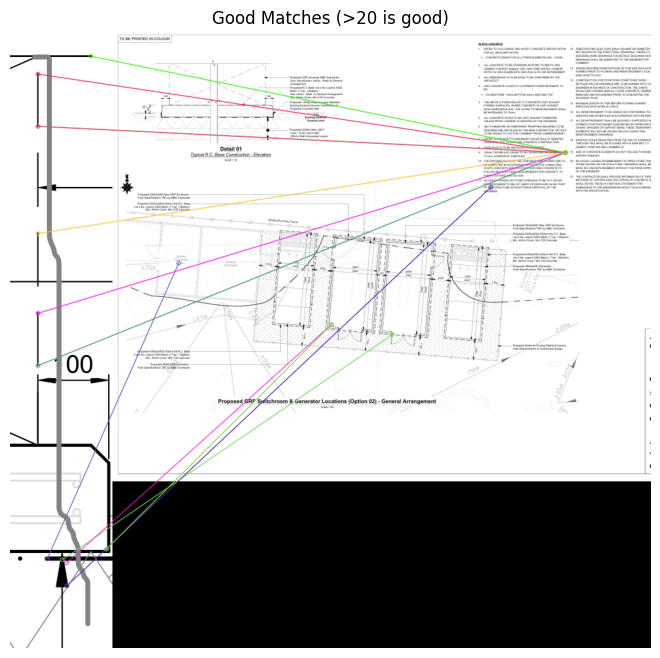

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# --- Load images in grayscale ---
full_img = cv2.imread("bigger.png", cv2.IMREAD_GRAYSCALE)
zoomed_img = cv2.imread("smaller2.png", cv2.IMREAD_GRAYSCALE)

# Check images loaded properly
if full_img is None or zoomed_img is None:
    raise FileNotFoundError("One or both images not found or path is wrong.")

print(f"Full image shape: {full_img.shape}")
print(f"Zoomed image shape: {zoomed_img.shape}")

# --- Initialize SIFT detector ---
sift = cv2.SIFT_create()

# --- Detect keypoints and descriptors ---
kp1, des1 = sift.detectAndCompute(zoomed_img, None)
kp2, des2 = sift.detectAndCompute(full_img, None)

# Check descriptors found
if des1 is None or des2 is None:
    raise ValueError("Could not find descriptors in one or both images. Images might be too sparse or blank.")

print(f"Keypoints in zoomed image: {len(kp1)}")
print(f"Keypoints in full image: {len(kp2)}")

# --- Set up FLANN matcher ---
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# --- Match descriptors using k-NN ---
matches = flann.knnMatch(des1, des2, k=2)

# --- Apply Lowe's ratio test ---
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Good matches found: {len(good_matches)}")

# --- Decision heuristic ---
MIN_MATCH_COUNT = 20
if len(good_matches) > MIN_MATCH_COUNT:
    print("✅ Likely the zoomed image is part of the full image.")
else:
    print("❌ Unlikely the zoomed image is part of the full image.")

# --- Visualize matches ---
matched_img = cv2.drawMatches(
    zoomed_img, kp1, full_img, kp2, good_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(16, 8))
plt.imshow(matched_img, cmap='gray')
plt.title(f"Good Matches (>{MIN_MATCH_COUNT} is good)")
plt.axis('off')
plt.show()


Full image shape: (720, 862)
Zoomed image shape: (599, 1153)
Keypoints in zoomed image: 108
Keypoints in full image: 2000
Good matches found: 20
✅ Likely the zoomed image is part of the full image.


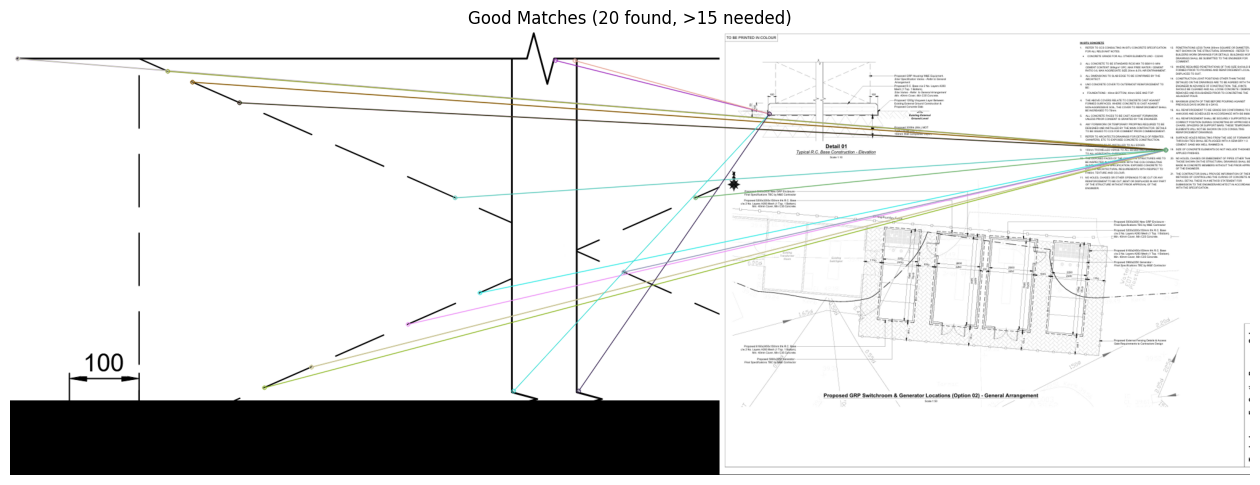

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# --- Load images in grayscale ---
full_img = cv2.imread("bigger.png", cv2.IMREAD_GRAYSCALE)
zoomed_img = cv2.imread("smaller.png", cv2.IMREAD_GRAYSCALE)

# Check images loaded properly
if full_img is None or zoomed_img is None:
    raise FileNotFoundError("One or both images not found or path is wrong.")

print(f"Full image shape: {full_img.shape}")
print(f"Zoomed image shape: {zoomed_img.shape}")

# --- Initialize SIFT detector with more features for architecture ---
sift = cv2.SIFT_create(nfeatures=2000)  # Increase from default 0 (unlimited) to reasonable limit

# --- Detect keypoints and descriptors ---
kp1, des1 = sift.detectAndCompute(zoomed_img, None)
kp2, des2 = sift.detectAndCompute(full_img, None)

# Check descriptors found
if des1 is None or des2 is None:
    raise ValueError("Could not find descriptors in one or both images.")

print(f"Keypoints in zoomed image: {len(kp1)}")
print(f"Keypoints in full image: {len(kp2)}")

# --- Set up FLANN matcher ---
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# --- Match descriptors using k-NN ---
matches = flann.knnMatch(des1, des2, k=2)

# --- Apply Lowe's ratio test (slightly stricter for architecture) ---
good_matches = []
for match_pair in matches:
    if len(match_pair) == 2:  # Ensure we have 2 matches
        m, n = match_pair
        if m.distance < 0.7 * n.distance:  # Stricter ratio for precision
            good_matches.append(m)

print(f"Good matches found: {len(good_matches)}")

# --- Decision heuristic ---
MIN_MATCH_COUNT = 15  # Slightly lower threshold
if len(good_matches) > MIN_MATCH_COUNT:
    print("✅ Likely the zoomed image is part of the full image.")
else:
    print("❌ Unlikely the zoomed image is part of the full image.")

# --- Visualize matches ---
matched_img = cv2.drawMatches(
    zoomed_img, kp1, full_img, kp2, good_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(16, 8))
plt.imshow(matched_img, cmap='gray')
plt.title(f"Good Matches ({len(good_matches)} found, >{MIN_MATCH_COUNT} needed)")
plt.axis('off')
plt.show()